# Start

In [1]:
#!pip install --upgrade pip
# !pip install git+https://github.com/qubvel/segmentation_models
#!pip install -U segmentation-models==0.2.1
#!pip install albumentations
#!pip install pandas
#!pip install seaborn
#!pip install tqdm
#!pip install pandas
#!pip install sklearn
#!pip install opencv-python
#!pip install keras==2.2.4
#!pip install keras==2.4.3

In [2]:
#import tensorflow.compat.v1 as tf
import tensorflow as tf

#tf.disable_v2_behavior() 
#tf.compat.v1.disable_eager_execution()

import os, sys, gc

import pandas as pd
import numpy  as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto       import tqdm
from multiprocessing import Pool, cpu_count

from cv2        import resize
from skimage.io import imread     as skiImgRead
# from imgaug     import augmenters as iaa, HooksImages

from skimage.morphology import label

from sklearn.model_selection import train_test_split

from segmentation_models           import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.utils     import set_trainable
from segmentation_models.losses    import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics   import iou_score, f2_score

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [3]:
#from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

In [4]:
IMG_HW    = 768
ZOOM_HW   = 384

DATA_DIR  = './data/airbus-ship-detection'
TRAIN_DIR = os.path.join(DATA_DIR, 'train_v2')
TEST_DIR  = os.path.join(DATA_DIR, 'test_v2')

BACKBONE  = 'resnet34'

preprocess_input = get_preprocessing(BACKBONE)

In [5]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(IMG_HW*IMG_HW, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(IMG_HW,IMG_HW).T


def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
def count_pix_inpool(df_col):
    pool = Pool()
    res = pool.map( count_pix, df_col.items() )
    pool.close()
    pool.join()
    return res

def count_pix(row):
    v = row[1]
    if v is np.nan or type(v) != str: 
        return v
    else:
        return rle_decode(v).sum()

# Load data

In [7]:
train_csv  = pd.read_csv( os.path.join( DATA_DIR, 'train_ship_segmentations_v2.csv') )
train_csv['withShip'] = ~train_csv['EncodedPixels'].isnull()
train_csv['npixel'] = count_pix_inpool( train_csv['EncodedPixels'] )

# EDA

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
W0430 20:33:02.293112 140026886518592 legend.py:1282] No handles with labels found to put in legend.


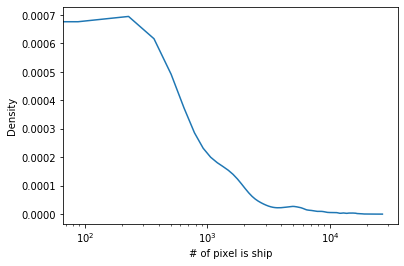

In [8]:
sns.kdeplot(train_csv['npixel'])
plt.xscale('log')
plt.legend().set_visible(False)
plt.xlabel('# of pixel is ship')
plt.ylabel('Density')
plt.show()

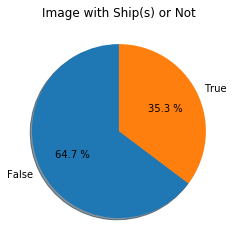

In [9]:
plt.pie(
    x       = (train_csv['withShip'].value_counts()/train_csv.shape[0]).values, 
    labels  = (train_csv['withShip'].value_counts()/train_csv.shape[0]).index,
    autopct = '%3.1f %%',
    shadow  = True, 
    labeldistance = 1.1, 
    startangle  = 90,
    pctdistance = 0.6
);
plt.title('Image with Ship(s) or Not');
plt.show()

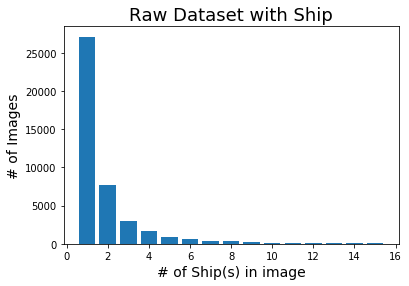

In [10]:
figdf = train_csv.dropna().groupby('ImageId').count()['withShip'].value_counts()
plt.bar(figdf.index, figdf.values)
plt.xlabel('# of Ship(s) in image', fontsize=14)
plt.ylabel('# of Images', fontsize=14)
plt.title('Raw Dataset with Ship', fontsize=18)
plt.show()

In [11]:
np.sqrt( train_csv['npixel'].min() )

1.4142135623730951

# Balance the data

In [12]:
DROP_NO_SHIP_FRACTION = 0.8

balanced_train_csv = (
    train_csv
    .set_index('ImageId')
    .drop(
        train_csv.loc[
            train_csv.isna().any(axis=1),
            'ImageId'
        ].sample( frac = DROP_NO_SHIP_FRACTION )
    )
    .drop(
        train_csv.query('npixel<32')['ImageId']
    )
    .reset_index()
)

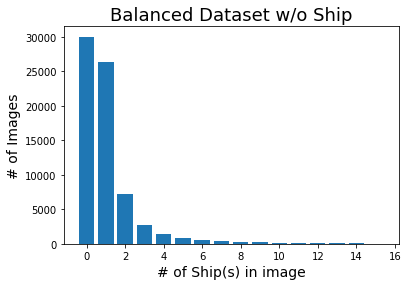

In [13]:
figdf = balanced_train_csv.fillna(0).groupby('ImageId').sum()['withShip'].value_counts()
plt.bar(figdf.index, figdf.values)
plt.xlabel('# of Ship(s) in image', fontsize=14)
plt.ylabel('# of Images', fontsize=14)
plt.title('Balanced Dataset w/o Ship', fontsize=18)
plt.show()

# Generate data for model

In [14]:
b_train_csv, b_valid_csv = train_test_split(balanced_train_csv['ImageId'], test_size = 0.2)

b_train_csv = balanced_train_csv.set_index('ImageId').loc[b_train_csv].reset_index()
b_valid_csv = balanced_train_csv.set_index('ImageId').loc[b_valid_csv].reset_index()

In [15]:
def batch_data_gen(csv_df, dir_prefix, batch_size, augmentation=None):
    name_idx_df = csv_df.set_index('ImageId')

#     img_ids = name_idx_df.index.unique().to_numpy()
    img_ids = np.array( name_idx_df.index.unique().tolist() )

    n_imgs  = img_ids.shape[0]
    
    while True:
        np.random.shuffle(img_ids)
        for idx in range(0, n_imgs, batch_size):
            batch_x = np.zeros( (batch_size,) + (ZOOM_HW, ZOOM_HW, 3) )
            batch_y = np.zeros( (batch_size,) + (ZOOM_HW, ZOOM_HW, 1) )

            end_idx = idx + batch_size
            batch_img_ids = img_ids[idx:end_idx]
            
            for i,img_id in enumerate(batch_img_ids):
                img_df = name_idx_df.loc[[img_id]]
                x, y = load_paired_data(img_df, dir_prefix, augmentation=augmentation)
                batch_x[i] += x
                batch_y[i] += y
            
            yield batch_x, batch_y



def load_paired_data(df, dir_prefix, augmentation=None):
    img_id = df.index.unique()[0]

    try:
        image = preprocess_input( skiImgRead( os.path.join(dir_prefix, img_id) ) )
    except:
        image = preprocess_input( np.zeros((IMG_HW, IMG_HW, 3), dtype=np.uint8) )

    mask = np.zeros((IMG_HW, IMG_HW, 1))
    for _,mask_rle in df['EncodedPixels'].iteritems():
        if mask_rle is np.nan:
            continue
        mask[:,:,0] += rle_decode(mask_rle)

    if augmentation:
        augmented = augmentation(image=image, mask=mask)
        image = augmented['image']
        mask  = augmented['mask']
    
    image = resize(image, (ZOOM_HW,ZOOM_HW))
    mask  = resize(mask.reshape(IMG_HW,IMG_HW), (ZOOM_HW,ZOOM_HW)).reshape((ZOOM_HW,ZOOM_HW,1))
    return image, mask

In [16]:
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, Transpose,
    OneOf, ToFloat,
    RandomBrightness, RandomContrast, RandomGamma, CLAHE,
    GridDistortion, ElasticTransform, JpegCompression,
    RGBShift, GaussNoise, IAAAdditiveGaussianNoise, HueSaturationValue,
    Blur, MotionBlur, MedianBlur, RandomBrightnessContrast,
    GridDistortion, OpticalDistortion, RandomSizedCrop, CenterCrop
)

augmentor = Compose([
    OneOf([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        Transpose(),
    ], p=0.8), 
    ShiftScaleRotate(rotate_limit=20),
    OneOf([
        MotionBlur(blur_limit=3),
        MedianBlur(blur_limit=3),
        Blur(blur_limit=3),
    ], p=0.3),
    OneOf([
        RandomGamma(),
        RandomContrast(),
        RandomBrightness(),
        CLAHE(),
     ], p=0.3),
    OneOf([
        IAAAdditiveGaussianNoise(),
        HueSaturationValue(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        ElasticTransform(),
        OpticalDistortion(),
        GridDistortion(),
    ], p=0.3),
    RandomSizedCrop(min_max_height=(IMG_HW/2, IMG_HW), height=IMG_HW, width=IMG_HW, p=0.3),
    ToFloat(max_value=1),
],p=1)

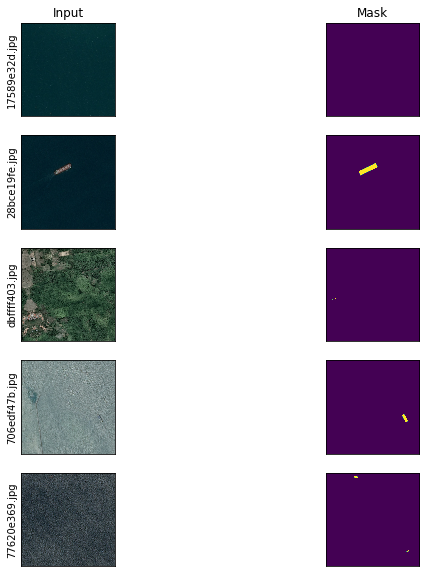

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 10), sharex=True, sharey=True)

for i, img_id in enumerate( np.random.choice(train_csv.dropna()['ImageId'].unique(), 5) ):
#     print (img_id)
    img_df = train_csv.set_index('ImageId').loc[[img_id]]
    x, y = load_paired_data(img_df, TRAIN_DIR, augmentation=augmentor)

    axs[i,0].set_ylabel(img_id)
    axs[i,0].imshow(x/255)
    axs[i,1].imshow(y[:,:,0])

axs[0,0].set_title('Input')
axs[0,1].set_title('Mask')

plt.xticks([])
plt.yticks([])

plt.show()

In [18]:
model = Unet(
    BACKBONE, 
    encoder_weights='imagenet',
    classes=1, 
    activation='sigmoid', 
    input_shape=(ZOOM_HW, ZOOM_HW, 3),
    decoder_filters=(128, 64, 32, 16, 8),
)

# model.compile('Adam', loss='binary_crossentropy')
model.compile(optimizer='Adam', loss=bce_dice_loss, metrics=[iou_score])
# model.compile(optimizer='Adadelta', loss=bce_dice_loss, metrics=[iou_score])

W0430 20:33:05.747978 140026886518592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0430 20:33:05.770843 140026886518592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0430 20:33:05.771589 140026886518592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0430 20:33:05.772151 140026886518592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0430 20:33:05.772813 140026

In [40]:
print(model.summary())
print(model.input)
print(model.input.op)
print(model.input.op.name)

print(model.output)
print(model.output.op)
print(model.output.op.name)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 384, 384, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 390, 390, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 192, 192, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [36]:
BATCH_SIZE = 32

In [37]:
b_train_csv['ImageId'].unique().shape[0]//BATCH_SIZE

1839

In [38]:
checkpoint = ModelCheckpoint(
    filepath='./best_model.h5', 
    monitor='val_iou_score', mode='max', 
    save_best_only=True, save_weights_only=False, 
    verbose=1
)

reduce_lr  = ReduceLROnPlateau(
    monitor='val_loss', mode='min', 
    factor=0.3, patience=3, min_lr=0.00001, 
    verbose=1
)

In [39]:
history = model.fit_generator(
    generator        = batch_data_gen(b_train_csv, TRAIN_DIR, BATCH_SIZE, augmentation=None), 
    validation_data  = batch_data_gen(b_valid_csv, TRAIN_DIR, BATCH_SIZE), 
    validation_steps = 50,
    steps_per_epoch  = 500,
    epochs           = 1,
    verbose = 1,
    callbacks=[ checkpoint, reduce_lr ]
)

Epoch 1/1
500/500 [==============================] - 443s 887ms/step - loss: 0.7643 - iou_score: 0.2888 - val_loss: 0.9860 - val_iou_score: 0.1067

Epoch 00001: val_iou_score improved from -inf to 0.10673, saving model to ./best_model.h5


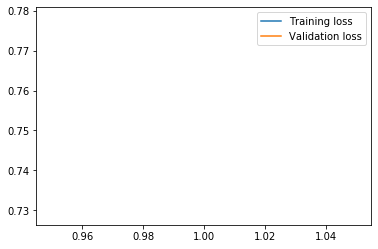

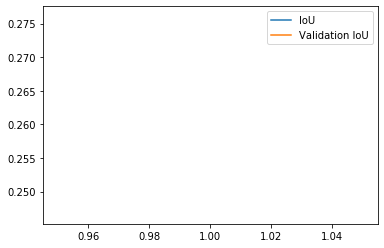

In [25]:
los  = model.history.history['loss']
vlos = model.history.history['val_loss']
iou  = model.history.history['iou_score']
viou = model.history.history['val_iou_score']

epochs = np.arange(1, len(los)+1)
plt.plot(epochs, los,  label='Training loss')
plt.plot(epochs, vlos, label='Validation loss')
plt.legend()
plt.show()

epochs = np.arange(1, len(los)+1)
plt.plot(epochs, iou,  label='IoU')
plt.plot(epochs, viou, label='Validation IoU')
plt.legend()
plt.show()


In [ ]:
model.load_weights('best_model.h5')

In [ ]:
lrs = LearningRateScheduler(lambda epoch: 0.001 * 0.3 ** (epoch // 2))
                      
history = model.fit_generator(
    generator        = batch_data_gen(b_train_csv, TRAIN_DIR, BATCH_SIZE, augmentation=augmentor), 
    validation_data  = batch_data_gen(b_valid_csv, TRAIN_DIR, BATCH_SIZE), 
    validation_steps = 20,
    steps_per_epoch  = 150,
    epochs           = 1,
    verbose = 2,
    callbacks=[ checkpoint, lrs ],
)

In [ ]:
los  = model.history.history['loss']
vlos = model.history.history['val_loss']
iou  = model.history.history['iou_score']
viou = model.history.history['val_iou_score']

epochs = np.arange(1, len(los)+1)
plt.plot(epochs, los,  label='Training loss')
plt.plot(epochs, vlos, label='Validation loss')
plt.legend()
plt.show()

epochs = np.arange(1, len(los)+1)
plt.plot(epochs, iou,  label='IoU')
plt.plot(epochs, viou, label='Validation IoU')
plt.legend()
plt.show()

In [31]:
model.load_weights('best_model.h5')

6647755f3.jpg
5acee1b08.jpg
66039a7fc.jpg
0ed60a1e4.jpg
7b4c244b5.jpg


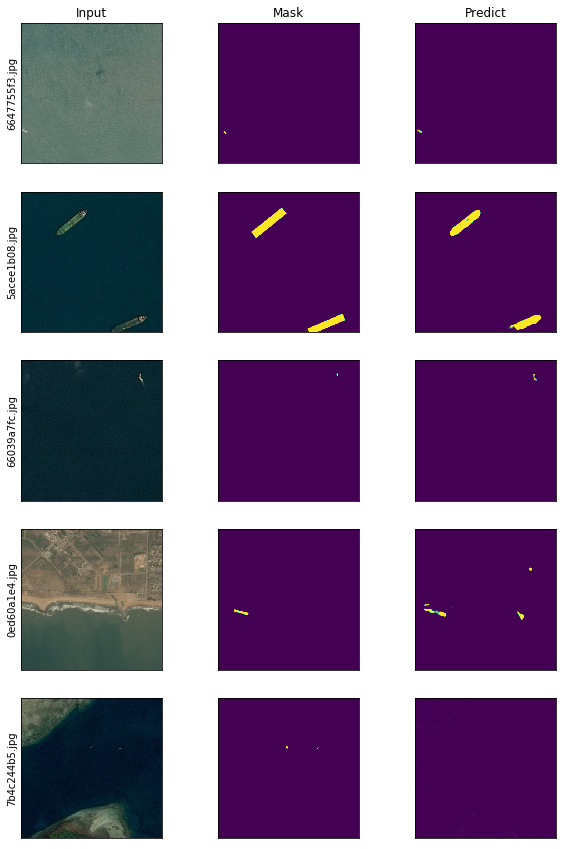

In [32]:
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(10, 15), sharex=True, sharey=True)

for i, img_id in enumerate( np.random.choice(train_csv.dropna()['ImageId'].unique(), 5) ):
    print (img_id)
    img_df = train_csv.set_index('ImageId').loc[[img_id]]
    x, y = load_paired_data(img_df, TRAIN_DIR)
    yp = model.predict( np.expand_dims(preprocess_input(x), axis=0) )

    axs[i,0].set_ylabel(img_id)
    axs[i,0].imshow(x)
    axs[i,1].imshow(y[:,:,0])
    axs[i,2].imshow(yp[0,:,:,0])

axs[0,0].set_title('Input')
axs[0,1].set_title('Mask')
axs[0,2].set_title('Predict')

plt.xticks([])
plt.yticks([])

plt.show()

In [34]:
sub_csv = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

for test_id in tqdm( os.listdir( TEST_DIR ) ):
    fp  = os.path.join( TEST_DIR, test_id )
    img = skiImgRead(fp)
    assert ( img.shape == (IMG_HW, IMG_HW, 3) ), 'Bad Shape in image: "{}"'.format(fp)

    img = resize(img, (ZOOM_HW, ZOOM_HW))

    # TTA
    imgTTA1 = preprocess_input(img).reshape(1, ZOOM_HW, ZOOM_HW, 3)
    
    imgTTA1 = imgTTA1[:, :: 1, :: 1, :]
    imgTTA2 = imgTTA1[:, :: 1, ::-1, :]
    imgTTA3 = imgTTA1[:, ::-1, :: 1, :]
    imgTTA4 = imgTTA1[:, ::-1, ::-1, :]
    
    (rTTA1,rTTA2,rTTA3,rTTA4) = model.predict( np.concatenate( [imgTTA1, imgTTA2, imgTTA3, imgTTA4] ) )[:,:,:,0]

    result = (
        rTTA1[:: 1, :: 1] + 
        rTTA2[:: 1, ::-1] + 
        rTTA3[::-1, :: 1] + 
        rTTA4[::-1, ::-1]
    )/4
    
    result = resize(result, (IMG_HW, IMG_HW))
    labels = label( (result>0.5)+0 )

    
    # No Ship
    if labels.max() == 0:
        sub_csv = sub_csv.append({'ImageId':test_id}, ignore_index=True)
    else:
        for k in np.unique(labels[labels>0]):
            sub_csv = sub_csv.append(
                {
                    'ImageId'      : test_id, 
                    'EncodedPixels': rle_encode(labels==k)
                }, ignore_index=True)
#     break

  0%|          | 0/15606 [00:00<?, ?it/s]

In [35]:
sub_csv.to_csv('submission.csv', index=False)

In [53]:
from keras import backend as K
print(model.output.op.name)
saver = tf.train.Saver(write_version=1)
saver.save(K.get_session(), 'models/final_model.ckpt',
    strip_default_attrs=True)

sigmoid/Sigmoid


W0430 19:59:01.536553 140262620841792 saver.py:1134] *******************************************************
W0430 19:59:01.537413 140262620841792 saver.py:1135] TensorFlow's V1 checkpoint format has been deprecated.
W0430 19:59:01.537871 140262620841792 saver.py:1136] Consider switching to the more efficient V2 format:
W0430 19:59:01.538322 140262620841792 saver.py:1137]    `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
W0430 19:59:01.538846 140262620841792 saver.py:1138] now on by default.
W0430 19:59:01.539381 140262620841792 saver.py:1139] *******************************************************


'models/final_model.ckpt'

In [52]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

from keras import backend as K

# Create, compile and train model...

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

tf.train.write_graph(frozen_graph, "./models", "final_model.pb", as_text=False)
tf.train.write_graph(frozen_graph, "./models", "final_model.pbtxt", as_text=True)

'./models/final_model.pbtxt'

In [41]:
#tf.compat.experimental.export_saved_model(model, fname) # tf 1